In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [9]:
%%capture
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [10]:
# Importing the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import pandas as pd
import os
import pickle
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [11]:
seed_constant = 42
np.random.seed(seed_constant)

random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [12]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

robbery_GD_path='/content/drive/MyDrive/Data298b_robbery/Training/Robbery'
normal_GD_path='/content/drive/MyDrive/Data298b_robbery/Training/Normal'
robbery_dir = os.listdir(robbery_GD_path)
normal_dir=os.listdir(normal_GD_path)


<Figure size 1440x1440 with 0 Axes>

In [13]:
print(len(robbery_dir))
print(len(normal_dir))

165
148


In [14]:
plt.figure(figsize = (20, 20))

# Get the names of all classes our dataset.
all_classes_names = os.listdir(r"/content/drive/MyDrive/Data298b_robbery/Training")

all_classes_names

['Robbery', 'Normal']

<Figure size 1440x1440 with 0 Axes>

In [15]:
random_range = random.sample(range(len(all_classes_names)), 2)

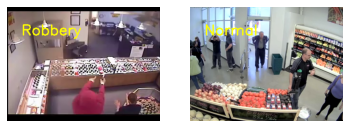

In [16]:
for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Data298b_robbery/Training/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Data298b_robbery/Training/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    
    plt.subplot(1, 2, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [17]:
SEQUENCE_LENGTH = 18

IMAGE_HEIGHT= 210

IMAGE_WIDTH= 210

DATASET_DIR = r"/content/drive/MyDrive/Data298b_robbery/Training/"

CLASSES_LIST = ["Normal","Robbery"]  

In [18]:
def frames_extraction(video_path):

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterating through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [19]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [12]:
features, labels, video_files_paths=create_dataset()

Extracting Data of Class: Normal
Extracting Data of Class: Robbery


Pickling

In [2]:
# creating pickle file to save the extracted features
import pickle
import os

In [13]:


pickle.dump(features,open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResNetV2_1_features.dat","wb"), protocol=4)
pickle.dump(labels,open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResNetV2_1_labels.dat","wb"), protocol=4)
pickle.dump(video_files_paths,open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResNetV2_1_video_files_paths.dat","wb"), protocol=4)

In [3]:
features=pickle.load(open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResNetV2_1_features.dat","rb"))
labels=pickle.load(open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResNetV2_1_labels.dat","rb"))
video_files_paths=pickle.load(open("/content/drive/MyDrive/Data298b_robbery/Pickled_models/robberyAndNormal_InceptionResNetV2_1_video_files_paths.dat","rb"))

In [20]:
one_hot_encoded_labels = to_categorical(labels)

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,test_size = 0.2, shuffle = True,random_state = seed_constant)

In [22]:
from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, LSTM,  Flatten, TimeDistributed, Conv2D, Dropout,Activation
from keras import Sequential
from keras.models import Model
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import regularizers

inceptionResnetV2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for layer in inceptionResnetV2.layers:
    layer.trainable = False

In [51]:
def create_inceptionResnetV2_LSTM_model():

    model= Sequential()     
  
    model.add(TimeDistributed(inceptionResnetV2, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(Dense(256, activation="relu"))

    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(Dense(128, activation="relu"))

    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(Dense(64, activation="relu"))

    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(Dense(32, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)))

    model.add(Dense(16, activation="relu"))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(64, activation='relu', return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dropout(0.2))

    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    return model

In [52]:
inceptionResnetV2_model = create_inceptionResnetV2_LSTM_model()

In [53]:
inceptionResnetV2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 18, 5, 5, 1536)   54336736  
 stributed)                                                      
                                                                 
 dense_25 (Dense)            (None, 18, 5, 5, 256)     393472    
                                                                 
 time_distributed_23 (TimeDi  (None, 18, 5, 5, 256)    0         
 stributed)                                                      
                                                                 
 dense_26 (Dense)            (None, 18, 5, 5, 128)     32896     
                                                                 
 time_distributed_24 (TimeDi  (None, 18, 5, 5, 128)    0         
 stributed)                                                      
                                                      

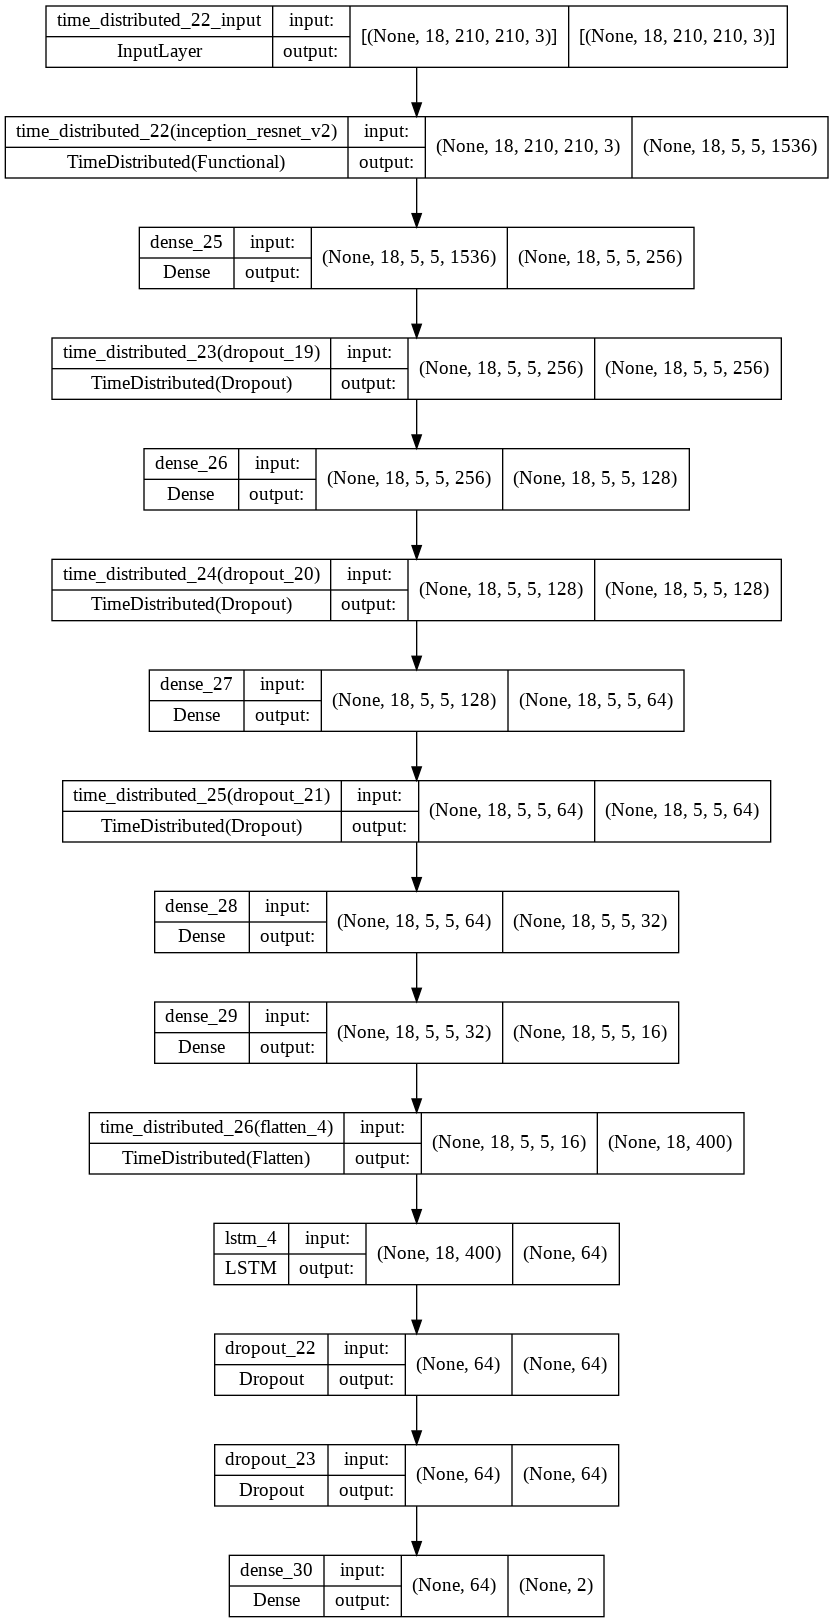

In [54]:
# Plot the structure of the ConvLSTM model.
plot_model(inceptionResnetV2_model, to_file = '/content/drive/MyDrive/Data298b_robbery/constructed_model/inceptionResnetV2_model_structure.png', show_shapes = True, show_layer_names = True)

In [55]:
# compile the model
optim = Adam(lr=1e-3, decay=1e-3 / 25)
inceptionResnetV2_model.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])

In [56]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Start training the model.
inceptionResnetV2_training_history = inceptionResnetV2_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 10 ,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/50
20/20 [==============================] - 32s 879ms/step - loss: 0.7663 - accuracy: 0.5300 - val_loss: 0.7028 - val_accuracy: 0.6400
Epoch 2/50
20/20 [==============================] - 11s 540ms/step - loss: 0.6951 - accuracy: 0.6700 - val_loss: 0.6816 - val_accuracy: 0.7200
Epoch 3/50
20/20 [==============================] - 11s 537ms/step - loss: 0.6353 - accuracy: 0.7000 - val_loss: 0.5358 - val_accuracy: 0.8600
Epoch 4/50
20/20 [==============================] - 10s 519ms/step - loss: 0.5612 - accuracy: 0.7150 - val_loss: 0.5982 - val_accuracy: 0.7600
Epoch 5/50
20/20 [==============================] - 10s 517ms/step - loss: 0.5849 - accuracy: 0.8200 - val_loss: 0.5397 - val_accuracy: 0.7000
Epoch 6/50
20/20 [==============================] - 11s 539ms/step - loss: 0.5629 - accuracy: 0.7750 - val_loss: 0.4564 - val_accuracy: 0.8400
Epoch 7/50
20/20 [==============================] - 10s 520ms/step - loss: 0.5046 - accuracy: 0.8000 - val_loss: 0.5665 - val_accuracy: 0.8200

In [59]:
inceptionResnetV2_test_history = inceptionResnetV2_model.evaluate(features_test, labels_test)
print("%s: %.2f%%" % (inceptionResnetV2_model.metrics_names[1], inceptionResnetV2_test_history[1]*100))
print("Loss: %.2f%%" %((inceptionResnetV2_test_history[0]*100)))

2/2 [==============================] - 2s 1s/step - loss: 0.3659 - accuracy: 0.8889
accuracy: 88.89%
Loss: 36.59%


In [60]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

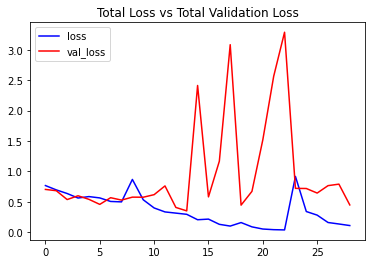

In [61]:
# Visualizing the training and validation loss metrices.
plot_metric(inceptionResnetV2_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

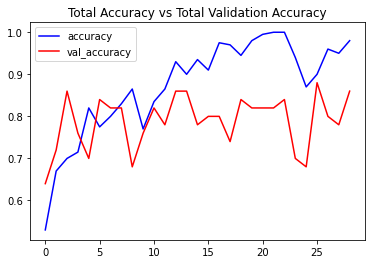

In [62]:
# Visualizing the training and validation accuracy metrices.
plot_metric(inceptionResnetV2_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Evaluation Metrics

In [63]:
#Changing the 2D array to 1D for compatibility.
import numpy as np
rounded_ytest=np.argmax(labels_test, axis=1)
print(rounded_ytest.shape)

(63,)


In [64]:
# generate a majority class prediction 
ns_probs = [0 for _ in range(len(rounded_ytest))]

In [65]:
# predict probabilities
yhat_probs = inceptionResnetV2_model.predict_on_batch(features_test)

In [66]:
# keeping the probabilities for the positive outcome only
yhat_probs = yhat_probs[:, 1]

In [67]:
# calculating the scores
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_AUC = roc_auc_score(rounded_ytest, ns_probs)
yhat_probs_AUC = roc_auc_score(rounded_ytest, yhat_probs)

In [68]:
# summarize scores
print('Majority class ROC_AUC : %.3f' % (ns_AUC))
print('ResNet ROC_AUC : %.3f' % (yhat_probs_AUC))

Majority class ROC_AUC : 0.500
ResNet ROC_AUC : 0.943


In [69]:
# calculate the roc curve values
ns_fpr, ns_tpr, _ = roc_curve(rounded_ytest, ns_probs)
yhat_fpr, yhat_tpr, _ = roc_curve(rounded_ytest, yhat_probs)

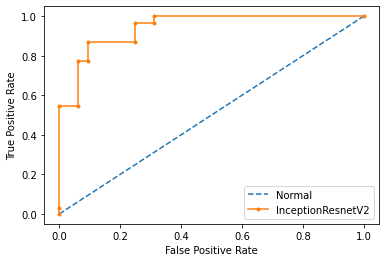

In [70]:
import matplotlib.pyplot as plt

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Normal')
plt.plot(yhat_fpr, yhat_tpr, marker='.', label='InceptionResnetV2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [71]:
#Prediction of lables for the unseen dataset
y_pred=inceptionResnetV2_model.predict(features_test)
y_pred[:5]

array([[8.02268863e-01, 2.31607378e-01],
       [1.00000000e+00, 1.61093605e-09],
       [2.39233226e-01, 7.75338113e-01],
       [9.99999881e-01, 1.62842099e-07],
       [1.00000000e+00, 1.19636825e-08]], dtype=float32)

Confusion matrix (Note: Robbery=1 and Normal=0)

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Robbery')]

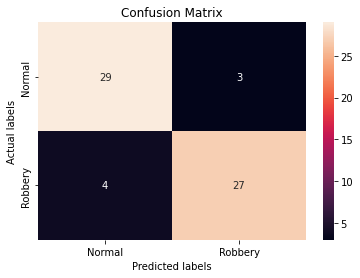

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lables = ['Normal','Robbery']  
ax= plt.subplot()
cm = confusion_matrix(np.asarray(labels_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables)

In [73]:
from sklearn.metrics import classification_report
y_pred = (y_pred > 0.5)
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.90      0.87      0.89        31

   micro avg       0.87      0.87      0.87        63
   macro avg       0.87      0.87      0.87        63
weighted avg       0.87      0.87      0.87        63
 samples avg       0.87      0.87      0.87        63



In [74]:
#Precision Score

from sklearn.metrics import precision_score

precision = precision_score(labels_test, y_pred, labels=[0,1], average='micro')
print(f'The precision score of the InceptionResnetV2 model is {round((precision*100),2)}%')

The precision score of the InceptionResnetV2 model is 87.3%


In [75]:
from sklearn.metrics import recall_score
recall = recall_score(labels_test, y_pred, labels=[0,1], average='micro')
print(f'The recall score of the InceptionResnetV2 model is {round((recall*100),2)}%')

The recall score of the InceptionResnetV2 model is 87.3%


In [76]:
from sklearn.metrics import f1_score
f1_score = f1_score(labels_test, y_pred, labels=[0,1], average='micro')
print(f'The f1_score of InceptionResnetV2 model is {round((f1_score*100),2)}%')

The f1_score of InceptionResnetV2 model is 87.3%


Save the trained model

In [77]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = inceptionResnetV2_test_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'/content/drive/MyDrive/Data298b_robbery/Save_model/inceptionResnetV2_Final_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
inceptionResnetV2_model.save(model_file_name)

Test on new unseen video


In [78]:
test_videos_directory = f'/content/drive/MyDrive/Data298b_robbery/Testing/Test_output'
os.makedirs(test_videos_directory, exist_ok = True)

input_video_file_path = f'/content/drive/MyDrive/Data298b_robbery/Testing/test_robbery003.mp4'

In [79]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = inceptionResnetV2_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        #cv2.putText(frame, predicted_class_name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4)

        if predicted_class_name=='Robbery':
        # Write predicted class name on top of the frame.
          cv2.putText(frame, predicted_class_name+ 'Alert!!', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        else:
           cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [80]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/test_robbery022_output.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|█████████▉| 429/430 [00:01<00:00, 303.96it/s]
